In [211]:
import pandas as pd

# Đường dẫn các file
nodes_path = "data/nodes.csv"
segments_path = "data/segments.csv"
streets_path = "data/streets.csv"
segment_status_path = "data/segment_status.csv"
train_path = "data/train.csv"

# Đọc dữ liệu
nodes_df = pd.read_csv(nodes_path)
segments_df = pd.read_csv(segments_path)
streets_df = pd.read_csv(streets_path)
segment_status_df = pd.read_csv(segment_status_path)
train_df = pd.read_csv(train_path)


In [212]:
# Hiển thị thông tin dữ liệu train
print("Train data:", train_df.shape)
print("Train columns:", train_df.columns.tolist())

# Chuyển 'date' thành datetime
train_df["timestamp"] = pd.to_datetime(train_df["date"])

# Tạo đặc trưng thời gian nếu chưa có
train_df["hour"] = train_df["timestamp"].dt.hour
train_df["is_weekend"] = train_df["weekday"] >= 5
train_df["is_peak_hour"] = train_df["hour"].apply(lambda h: 7 <= h <= 9 or 16 <= h <= 19)

# Thêm các cột segment_length, max_speed và dayofweek
train_df["dayofweek"] = train_df["timestamp"].dt.weekday  # Tạo cột 'dayofweek'
train_df["segment_length"] = train_df["length"]  # Tạo cột 'segment_length'
train_df["max_speed"] = train_df["max_velocity"]  # Tạo cột 'max_speed'

# Kiểm tra kết quả
train_df.head()


Train data: (33441, 18)
Train columns: ['_id', 'segment_id', 'date', 'weekday', 'period', 'LOS', 's_node_id', 'e_node_id', 'length', 'street_id', 'max_velocity', 'street_level', 'street_name', 'street_type', 'long_snode', 'lat_snode', 'long_enode', 'lat_enode']


,_id,segment_id,date,weekday,period,LOS,s_node_id,e_node_id,length,street_id,...,lat_snode,long_enode,lat_enode,timestamp,hour,is_weekend,is_peak_hour,dayofweek,segment_length,max_speed
0,0,26,2021-04-16,4,period_0_30,A,366428456,366416066,116,32575820,...,10.841506,106.769254,10.842422,2021-04-16,0,False,False,4,116,NaN
1,1,33,2020-08-02,6,period_23_30,C,366469460,3792257828,26,32575862,...,10.878650,106.762143,10.878808,2020-08-02,0,True,False,6,26,NaN
2,2,33,2020-08-03,0,period_0_00,D,366469460,3792257828,26,32575862,...,10.878650,106.762143,10.878808,2020-08-03,0,False,False,0,26,NaN
3,3,67,2021-03-09,1,period_9_30,B,366403668,5755066033,7,32575862,...,10.880817,106.768461,10.880771,2021-03-09,0,False,False,1,7,NaN
4,4,67,2021-03-23,1,period_9_30,B,366403668,5755066033,7,32575862,...,10.880817,106.768461,10.880771,2021-03-23,0,False,False,1,7,NaN


Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.73      0.63      2622
           1       0.45      0.50      0.47       967
           2       0.19      0.10      0.13       742
           3       0.28      0.23      0.26       736
           4       0.21      0.13      0.16       760
           5       0.36      0.28      0.31       862

    accuracy                           0.45      6689
   macro avg       0.34      0.33      0.33      6689
weighted avg       0.40      0.45      0.42      6689



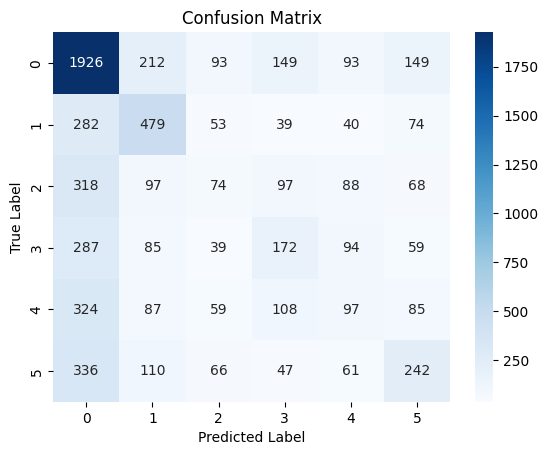

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn các đặc trưng đầu vào
feature_cols = [
    "hour", "dayofweek", "is_weekend", "is_peak_hour",
    "length", "max_velocity", "street_type"
]

# Xử lý nhãn dạng chuỗi: street_type (nếu có)
train_df["street_type"] = train_df["street_type"].fillna("unknown")  # xử lý thiếu
le = LabelEncoder()
train_df["street_type_encoded"] = le.fit_transform(train_df["street_type"])

# Chuẩn bị dữ liệu huấn luyện
X = train_df[[
    "hour", "dayofweek", "is_weekend", "is_peak_hour",
    "length", "max_velocity", "street_type_encoded"
]]

y = train_df["LOS"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Chia train/test
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_val)

# Đánh giá mô hình
print("Classification Report:\n", classification_report(y_val, y_pred))

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [214]:
import networkx as nx

# Tạo đồ thị có hướng
G = nx.DiGraph()

# Duyệt qua từng đoạn đường để thêm vào đồ thị
for _, row in segments_df.iterrows():
    start = row["s_node_id"]
    end = row["e_node_id"]
    length = row["length"]
    
    # Thêm cạnh với trọng số là độ dài đoạn đường
    G.add_edge(start, end, weight=length, segment_id=row["_id"])

print("Số lượng đỉnh:", G.number_of_nodes())
print("Số lượng cạnh:", G.number_of_edges())


Số lượng đỉnh: 52425
Số lượng cạnh: 84629


In [215]:
# Hàm tìm đường đi ngắn nhất giữa hai node
def find_shortest_path(start_node, end_node):
    try:
        path = nx.dijkstra_path(G, source=start_node, target=end_node, weight="weight")
        total_distance = nx.dijkstra_path_length(G, source=start_node, target=end_node, weight="weight")
        return path, total_distance
    except nx.NetworkXNoPath:
        return None, float("inf")

# Ví dụ: tìm đường đi từ node 100 đến node 200 (thay bằng ID thật trong dữ liệu)
start_node = 373543511
end_node = 696860119
shortest_path, total_distance = find_shortest_path(start_node, end_node)

if shortest_path:
    print("Đường đi ngắn nhất:", shortest_path)
    print("Tổng độ dài:", total_distance, "mét")
else:
    print("Không tìm được đường đi giữa hai nút.")

Đường đi ngắn nhất: [373543511, 5468660805, 5738158916, 5738158918, 5738158912, 5758104203, 2242413001, 4066528708, 4066528709, 4066528710, 2242412994, 4066528704, 2242412977, 1648965048, 2242412998, 4066528693, 1648965038, 2242412987, 4066528692, 4109615280, 5735541500, 5009095464, 4109615279, 5735541517, 4109615278, 5738158904, 4109615277, 4109615276, 373543561, 4988324910, 3164037418, 5737984606, 5737984550, 5737984608, 1648965109, 5737984561, 5748258032, 1648965013, 4979904021, 1648965115, 5752816761, 4275357751, 1648965076, 1648965122, 3164037420, 4979902519, 1648965050, 2326583123, 1648965074, 1648965135, 5757488250, 5797843791, 5757507443, 1648965044, 5757507440, 1648965046, 5797843785, 4276237051, 5797843769, 5797843890, 5797843765, 3164037422, 5009095767, 5797843852, 1648965053, 5797843848, 4988324906, 5023969313, 1648965133, 1648965011, 4319770607, 5757488304, 5794808757, 1648965067, 5797843905, 5023969312, 5797843904, 1648965043, 5794808808, 5797843885, 5794808742, 429213240

In [216]:
import pandas as pd
import folium

# Chuyển thành dict: node_id -> (lat, lon)
node_coords = {
    row['_id']: (row['lat'], row['long'])
    for _, row in nodes_df.iterrows()
}

# Bước 2: Hàm vẽ đường đi lên bản đồ
def visualize_path_on_map(path, node_coords):
    # Lấy tọa độ theo thứ tự các node trong path
    coordinates = []
    for node_id in path:
        if node_id in node_coords:
            coordinates.append(node_coords[node_id])
        else:
            print(f"Không tìm thấy tọa độ cho node {node_id}")

    if not coordinates:
        print("Không có tọa độ hợp lệ để vẽ.")
        return None

    # Lấy vị trí trung tâm bản đồ (node đầu tiên)
    start_lat, start_lon = coordinates[0]
    m = folium.Map(location=[start_lat, start_lon], zoom_start=15)

    # Vẽ tuyến đường
    folium.PolyLine(locations=coordinates, color='blue', weight=5).add_to(m)

    # Thêm marker cho điểm đầu và cuối
    folium.Marker(location=coordinates[0], popup="Start", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker(location=coordinates[-1], popup="End", icon=folium.Icon(color="red")).add_to(m)

    return m

# Bước 3: Gọi hàm vẽ nếu có đường đi
if shortest_path:
    m = visualize_path_on_map(shortest_path, node_coords)
    if m:
        m.save("shortest_path_map.html")
        print("Đã lưu bản đồ vào 'shortest_path_map.html'")
else:
    print("Không tìm được đường đi.")


Đã lưu bản đồ vào 'shortest_path_map.html'


In [217]:
status_to_speed = {
    0: 60,  # km/h
    1: 50,
    2: 40,
    3: 30,
    4: 20,
    5: 10
}

feature_names = [
    "hour", "dayofweek", "is_weekend", "is_peak_hour",
    "length", "max_velocity", "street_type_encoded"
]


# Hàm chuyển từ km/h sang m/s
def kmh_to_mps(kmh):
    return kmh * 1000 / 3600

# Hàm dự đoán ETA cho một đường đi
def estimate_eta(path, hour=8, dayofweek=1, is_weekend=False, is_peak_hour=True):
    total_time_sec = 0

    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]

        if G.has_edge(u, v):
            segment_id = G[u][v]['segment_id']
            segment_info = segments_df[segments_df['_id'] == segment_id].iloc[0]
            street_info = streets_df[streets_df['_id'] == segment_info['street_id']].iloc[0]

            # Xử lý street_type
            street_type = street_info["type"] if pd.notnull(street_info["type"]) else "unknown"
            if street_type in le.classes_:
                street_type_encoded = le.transform([street_type])[0]
            else:
                street_type_encoded = 0  # fallback nếu không nằm trong danh sách lớp đã huấn luyện

            # Tạo DataFrame đặc trưng với đúng tên cột
            features_df = pd.DataFrame([[
                hour,
                dayofweek,
                int(is_weekend),
                int(is_peak_hour),
                segment_info["length"],
                segment_info["max_velocity"],
                street_type_encoded
            ]], columns=feature_names)

            # Dự đoán tình trạng giao thông
            predicted_status = model.predict(features_df)[0]
            predicted_speed_kmh = status_to_speed.get(predicted_status, 10)
            predicted_speed_mps = kmh_to_mps(predicted_speed_kmh)

            # Tính thời gian (giây)
            time_sec = segment_info["length"] / predicted_speed_mps
            total_time_sec += time_sec

    return total_time_sec

# Ví dụ: Dự đoán ETA cho đường đi đã tìm ở bước trước
if shortest_path:
    eta_seconds = estimate_eta(
        shortest_path,
        hour=8,  # 8 giờ sáng
        dayofweek=1,  # Thứ 2
        is_weekend=False,
        is_peak_hour=True
    )
    print(f"ETA ước tính: {eta_seconds/60:.2f} phút")
else:
    print("Không thể dự đoán ETA vì không tìm được đường đi.")


ETA ước tính: 37.23 phút


In [219]:
from datetime import timedelta

def estimate_eta_dynamic(path, start_hour=8, dayofweek=1, is_weekend=False):
    total_time_sec = 0
    current_time_sec = start_hour * 3600  # Thời gian bắt đầu, tính bằng giây

    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]

        if G.has_edge(u, v):
            segment_id = G[u][v]['segment_id']
            segment_info = segments_df[segments_df['_id'] == segment_id].iloc[0]
            street_info = streets_df[streets_df['_id'] == segment_info['street_id']].iloc[0]

            # Cập nhật thời gian hiện tại (giờ) sau khi đã đi một đoạn
            current_hour = int(current_time_sec // 3600) % 24
            is_peak_hour = 7 <= current_hour <= 9 or 16 <= current_hour <= 18

            # Encode street type
            street_type = street_info["type"] if pd.notnull(street_info["type"]) else "unknown"
            street_type_encoded = le.transform([street_type])[0] if street_type in le.classes_ else 0

            features_df = pd.DataFrame([[
                current_hour,
                dayofweek,
                int(is_weekend),
                int(is_peak_hour),
                segment_info["length"],
                segment_info["max_velocity"],
                street_type_encoded
            ]], columns=feature_names)

            predicted_status = model.predict(features_df)[0]
            predicted_speed_kmh = status_to_speed.get(predicted_status, 10)
            predicted_speed_mps = kmh_to_mps(predicted_speed_kmh)

            # Thời gian đi qua đoạn này
            time_sec = segment_info["length"] / predicted_speed_mps
            total_time_sec += time_sec
            current_time_sec += time_sec  # cập nhật thời gian hiện tại
        else:
            print(f"Không có cạnh giữa {u} và {v}")

    return total_time_sec


# Ví dụ: Dự đoán ETA cho đường đi đã tìm ở bước trước
if shortest_path:
    eta_seconds = estimate_eta(
        shortest_path,
        hour=8,  # 8 giờ sáng
        dayofweek=1,  # Thứ 2
        is_weekend=False,
        is_peak_hour=True
    )
    print(f"ETA ước tính: {eta_seconds/60:.2f} phút")
else:
    print("Không thể dự đoán ETA vì không tìm được đường đi.")

ETA ước tính: 37.23 phút
